## **Tema**: Treinamento de uma CNN utilizando o dataset CIFAR-10, com uma análise comparativa entre diferentes bibliotecas.
___

## **Parte 1:** Análise exploratória e pré-processamento dos dados

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
print("===== Formato dos dados =====")
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

===== Formato dos dados =====
x_train: (50000, 32, 32, 3)
y_train: (50000, 1)
x_test: (10000, 32, 32, 3)
y_test: (10000, 1)


* Existem **50000** imagens no conjunto de treinamento e **10000** no conjunto de teste. </br>
* As imagens são de **32x32** pixels. </br>
* O **3** faz referência a matriz RGB para identificar a cor de cada pixel

Como no dataset não existe explicitamente o nome dos atributos vamos definir-los para facilitar o pré-processamento





In [ ]:
classes = ['aviao', 'automovel', 'passaro', 'gato', 'veado',
               'cachorro', 'sapo', 'cavalo', 'barco', 'caminhao']
#aviao: 0, automovel: 1, ... caminhao: 10

Para visualizar as 25 primeiras imagens do dataset

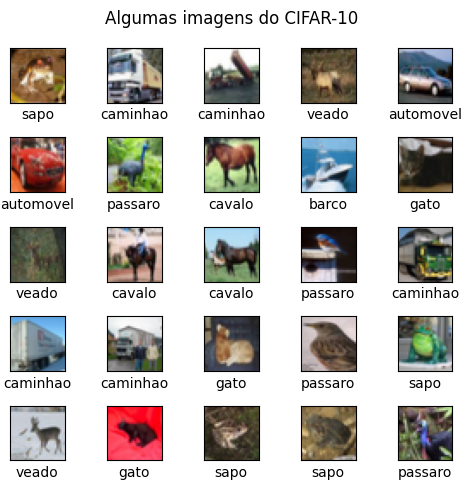

In [ ]:
plt.figure(figsize=(5, 5))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(classes[y_train[i][0]])
plt.suptitle('Algumas imagens do CIFAR-10', fontsize=12)
plt.tight_layout(rect=[0, 0.01, 1, 1])
plt.savefig('cifar10_sample_images.png')
plt.show()

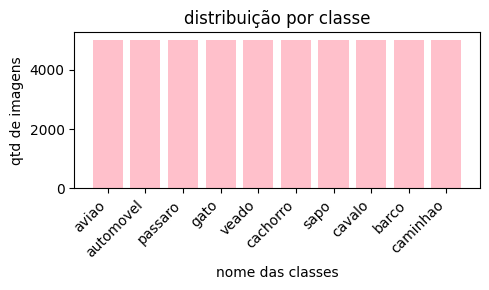

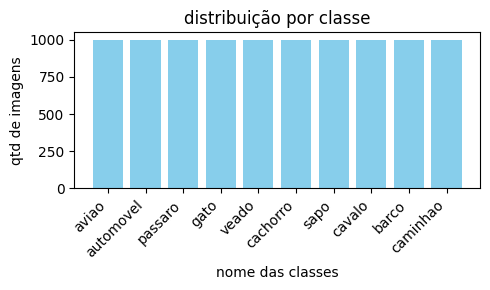

In [ ]:
# retorna a quantidade de classes
unique, counts = np.unique(y_train, return_counts=True)


plt.figure(figsize=(5, 3))
plt.bar(classes, counts, color='pink')
plt.xlabel('nome das classes')
plt.ylabel('qtd de imagens')
plt.title('distribuição por classe')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

unique, counts = np.unique(y_test, return_counts=True)


plt.figure(figsize=(5, 3))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('nome das classes')
plt.ylabel('qtd de imagens')
plt.title('distribuição por classe')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

É possível perceber que as classes estão igualmente distribuidas no *dataset*, cada uma tendo exatamente 5mil amostras no conjunto de treinamento e 10 mil no conjunto de teste

Para reduzir o tamanho do conjunto de dados, selecionamos apenas **três classes** que consideramos bem distintas, são elas:
* avião
* barco
* automóvel <br/>

A partir dessa redução, esperamos **simplificar o problema de classificação**, para diminuir o tempo de treinamento necessário e facilitar a análise dos resultados, sem comprometer o entendimento dos conceitos fundamentais envolvidos.

In [ ]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [ ]:
#as classe serão apenas aviao:0, automovel:1 e navio: 8
classes = [0, 1, 8]

#filtra o dataset para ter apenas as classes
mask_train = np.isin(y_train, classes).flatten()
x_train = x_train[mask_train]
y_train = y_train[mask_train]
mask_test = np.isin(y_test, classes).flatten()
x_test = x_test[mask_test]
y_test = y_test[mask_test]

# reindexar navio (índice 8 para 2)
y_train[y_train == 8] = 2
y_test[y_test == 8] = 2

In [ ]:
y_test

array([[2],
       [2],
       [0],
       ...,
       [0],
       [2],
       [1]], dtype=uint8)

In [ ]:
media_pixels = np.mean(x_train, axis=(0, 1, 2))
std_pixels = np.std(x_train, axis=(0, 1, 2))
print(f"média rgb dos pixels: {media_pixels}")
print(f"desvio padrão rgb dos pixels: {std_pixels}")

média rgb dos pixels: [126.40056491 130.92153919 135.21724349]
desvio padrão rgb dos pixels: [65.56178628 64.57908871 69.13642681]


In [ ]:
print(f"valor mínimo em um pixel: {np.min(x_train)}")
print(f"valor maximo em um pixel: {np.max(x_train)}")

valor mínimo em um pixel: 0
valor maximo em um pixel: 255


Os valores mínimo e máximo dos pixels indicam o intervalo dos dados, no caso do nosso dataset 0-255. <br/>
Através dessa informação podemos realizar a **normalização através da divisão por 255** para escalar os valores entre 0 e 1, o que vai facilitar o aprendizado do modelo.

In [ ]:
x_train = x_train/255.0
x_test = x_test/255.0

* **One-Hot enconding:**
Ao invés de representar a saída como um número indicando a classe, o One-Hot Encoding vai transforma esse número em um vetor binário. Nesse vetor, apenas a posição correspondente à classe verdadeira é marcada com 1, e todas as outras posições são 0.

Por exemplo, se temos 3 classes, o rótulo "classe 2" será representado como:
[0, 0, 1]

Isso permite que o modelo entenda a classe como uma distribuição categórica, facilitando o uso de funções de perda como a categorical_crossentropy.

In [ ]:
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [ ]:
y_test_cat

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

___
## **Parte 2:** Implementando a CNN

### **Usando Tensorflow/Keras**

###  Tuning de hiperparâmetros com TensorFlow/Keras


De modo a achar a **melhor configuração dos hiperparâmetros** para a CNN nesse dataset, este código realiza testes entre diferentes combinações de taxa de aprendizado, taxa de dropout e tamanho da camada densa oculta. <br/>
Cada configuração é avaliada com base na acurácia de validação obtida após o treinamento. Isso facilita a compreensão de como diferentes escolhas de hiperparâmetros afetam o desempenho do modelo.

* **Taxa de aprendizado:** define o quão grandes são os passos que o otimizador dá ao ajustar os pesos da rede durante o treinamento. <br/>
Aprendemos que uma taxa muito alta pode fazer o modelo oscilar e não convergir, enquanto uma taxa muito baixa pode deixar o treinamento lento ou travado em mínimos locais. <br/>
Por isso, testamos os valores `0.001` e `0.0005`, que através de pesquisas consideramos ser taxas frequentemente eficazes com o otimizador Adam.

* **Taxa de dropout:** representa a fração de neurônios que são desativados aleatoriamente durante o treinamento da rede. <br/>
Aprendemos que o dropout é uma técnica de regularização importante para evitar overfitting, pois obriga a rede a aprender representações mais robustas, sem depender excessivamente de neurônios específicos. <br/>
Neste experimento, testamos os valores `0.3` (30%) e `0.5` (50%), que são amplamente utilizados na literatura como taxas eficazes de regularização para redes convolucionais.

* **Tamanho da camada densa oculta:** refere-se ao número de neurônios na camada totalmente conectada que precede a saída do modelo. <br/>
Aprendemos que camadas maiores tendem a aumentar a capacidade de representação da rede, mas também elevam o risco de overfitting e o custo computacional. <br/>
Por isso, testamos os valores `64` e `128`, que representam configurações equilibradas entre simplicidade e poder de modelagem, e são comuns em tarefas de classificação de imagens.

Nessa etapa também utilizaremos apenas 3 épocas apenas para o tuning dos hiperparâmetros de depois implementaremos o melhor modelo com 10 épocas para melhor acurácia.

## Arquitetura do Modelo

O modelo implementado possui a seguinte arquitetura:

- **Duas camadas convolucionais completas**, cada uma composta por:
  - Uma convolução 2D (`Conv2D`) com **32** e **64 filtros**, respectivamente, kernel 3×3, ativação ReLU e padding `'same'`;
  - Uma normalização em lote (`BatchNormalization`) para estabilizar e acelerar o treinamento;
  - Uma operação de subamostragem (`MaxPooling2D`) com pool size 2×2 para redução da dimensionalidade .

- Após as camadas convolucionais:
  - As ativações são achatadas com `Flatten`;
  - Uma camada densa totalmente conectada (`Dense`) com **64 ou 128 neurônios** ;
  - Uma camada de `Dropout` com taxa de **30% ou 50%** é aplicada para reduzir overfitting;
  - A camada de saída é uma `Dense` com **3 neurônios** (correspondente ao número de classes) e ativação `softmax`, responsável por gerar as probabilidades de classificação.

O modelo foi treinado utilizando o otimizador **Adam**, função de perda **categorical crossentropy**, e métrica de **acurácia**.


In [ ]:
learning_rates = [0.001, 0.0005]
dropouts = [0.3, 0.5]
hidden_sizes = [64, 128]
resultados_tf = []

for lr in learning_rates:
    for dp in dropouts:
        for hs in hidden_sizes:
            print(f"🔧 TensorFlow - lr: {lr}, dropout: {dp}, hidden_size: {hs}")

            model = models.Sequential([
                layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
                layers.BatchNormalization(),
                layers.MaxPooling2D((2,2)),

                layers.Conv2D(64, (3,3), activation='relu', padding='same'),
                layers.BatchNormalization(),
                layers.MaxPooling2D((2,2)),

                layers.Flatten(),
                layers.Dense(hs, activation='relu'),
                layers.Dropout(dp),
                layers.Dense(3, activation='softmax')
            ])

            model.compile(optimizer=Adam(learning_rate=lr),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

            history = model.fit(x_train, y_train_cat,
                                epochs=3,
                                batch_size=32,
                                validation_data=(x_test, y_test_cat),
                                verbose=0)

            acc = history.history['val_accuracy'][-1] * 100
            resultados_tf.append({'lr': lr, 'dropout': dp, 'hidden': hs, 'acc': acc})
            print(f"Acurácia final (validação): {acc:.2f}%")


🔧 TensorFlow - lr: 0.001, dropout: 0.3, hidden_size: 64
Acurácia final (validação): 84.43%
🔧 TensorFlow - lr: 0.001, dropout: 0.3, hidden_size: 128
Acurácia final (validação): 84.27%
🔧 TensorFlow - lr: 0.001, dropout: 0.5, hidden_size: 64
Acurácia final (validação): 81.53%
🔧 TensorFlow - lr: 0.001, dropout: 0.5, hidden_size: 128
Acurácia final (validação): 80.20%
🔧 TensorFlow - lr: 0.0005, dropout: 0.3, hidden_size: 64
Acurácia final (validação): 85.80%
🔧 TensorFlow - lr: 0.0005, dropout: 0.3, hidden_size: 128
Acurácia final (validação): 85.13%
🔧 TensorFlow - lr: 0.0005, dropout: 0.5, hidden_size: 64
Acurácia final (validação): 85.37%
🔧 TensorFlow - lr: 0.0005, dropout: 0.5, hidden_size: 128
Acurácia final (validação): 85.13%


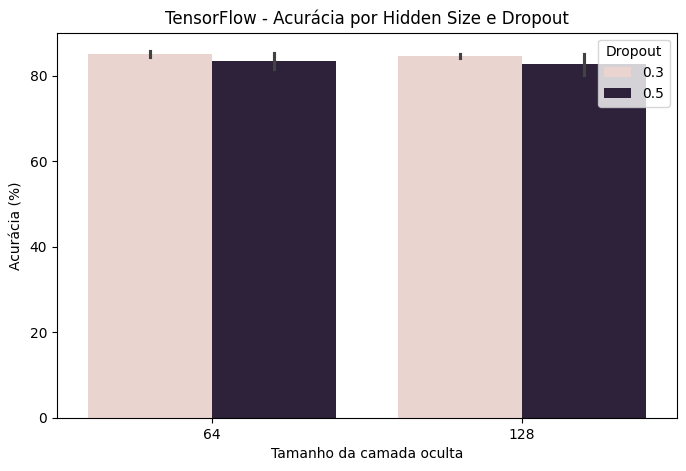

In [ ]:
df_tf = pd.DataFrame(resultados_tf)
plt.figure(figsize=(8,5))
sns.barplot(data=df_tf, x='hidden', y='acc', hue='dropout')
plt.title("TensorFlow - Acurácia por Hidden Size e Dropout")
plt.ylabel("Acurácia (%)")
plt.xlabel("Tamanho da camada oculta")
plt.legend(title="Dropout")
plt.show()


In [ ]:
model = models.Sequential([
                layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
                layers.BatchNormalization(),
                layers.MaxPooling2D((2,2)),

                layers.Conv2D(64, (3,3), activation='relu', padding='same'),
                layers.BatchNormalization(),
                layers.MaxPooling2D((2,2)),

                layers.Flatten(),
                layers.Dense(64, activation='relu'),
                layers.Dropout(0.3),
                layers.Dense(3, activation='softmax')
            ])

model.compile(optimizer=Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.fit(x_train, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test_cat),
    verbose=0)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **Avaliação do modelo:**

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
📋 Relatório de Classificação:
              precision    recall  f1-score   support

       aviao       0.85      0.84      0.85      1000
   automovel       0.87      0.94      0.90      1000
       navio       0.87      0.82      0.84      1000

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



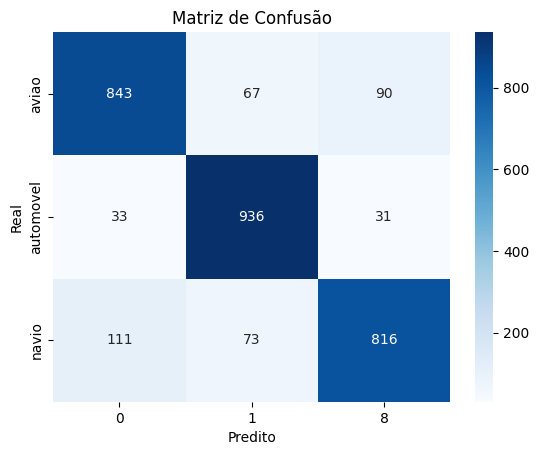

In [ ]:
classes_nomes = ["aviao", "automovel", "navio"]
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("📋 Relatório de Classificação:")
print(classification_report(y_test, y_pred_classes, target_names=classes_nomes))

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes_nomes, cmap='Blues')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

### **Usando Pytorch**

Tuning de hiperparâmetros com Pytorch

In [ ]:
resultados_pt = []

x_train_transposed = np.transpose(x_train, (0, 3, 1, 2))
x_test_transposed = np.transpose(x_test, (0, 3, 1, 2))

x_train_tensor = torch.tensor(x_train_transposed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_transposed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32)

class CNN_PyTorch_Tuned(nn.Module):
    def __init__(self, hidden_size, dropout_rate):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, 3)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr in learning_rates:
    for dp in dropouts:
        for hs in hidden_sizes:
            print(f"🔧 PyTorch - lr: {lr}, dropout: {dp}, hidden: {hs}")

            model = CNN_PyTorch_Tuned(hs, dp).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            model.train()
            for epoch in range(3):
                for inputs, labels in trainloader:
                  inputs, labels = inputs.to(device), labels.to(device)
                  labels = labels.view(-1)  # Remove dimensão extra, deixa shape (N,)
                  optimizer.zero_grad()
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  loss.backward()
                  optimizer.step()

            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    labels = labels.view(-1)  # Remove dimensão extra
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            acc = 100 * correct / total
            resultados_pt.append({'lr': lr, 'dropout': dp, 'hidden': hs, 'acc': acc})
            print(f"Acurácia: {acc:.2f}%")

🔧 PyTorch - lr: 0.001, dropout: 0.3, hidden: 64
Acurácia: 87.83%
🔧 PyTorch - lr: 0.001, dropout: 0.3, hidden: 128
Acurácia: 87.07%
🔧 PyTorch - lr: 0.001, dropout: 0.5, hidden: 64
Acurácia: 83.20%
🔧 PyTorch - lr: 0.001, dropout: 0.5, hidden: 128
Acurácia: 85.63%
🔧 PyTorch - lr: 0.0005, dropout: 0.3, hidden: 64
Acurácia: 86.80%
🔧 PyTorch - lr: 0.0005, dropout: 0.3, hidden: 128
Acurácia: 86.87%
🔧 PyTorch - lr: 0.0005, dropout: 0.5, hidden: 64
Acurácia: 85.57%
🔧 PyTorch - lr: 0.0005, dropout: 0.5, hidden: 128
Acurácia: 85.47%


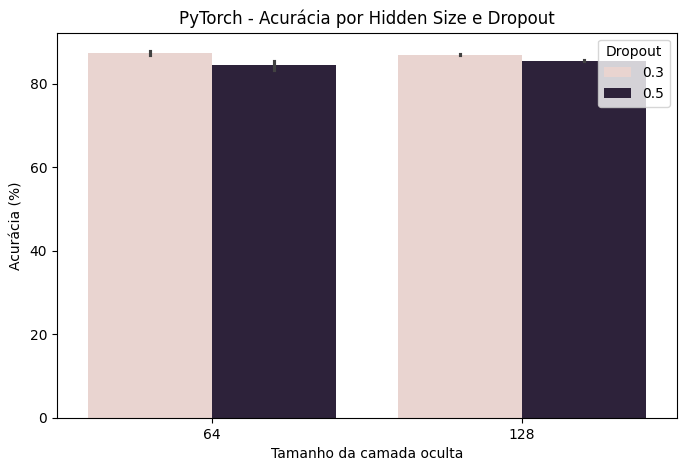

In [ ]:
#Visualização dos resultados
df_pt = pd.DataFrame(resultados_pt)
plt.figure(figsize=(8,5))
sns.barplot(data=df_pt, x='hidden', y='acc', hue='dropout')
plt.title("PyTorch - Acurácia por Hidden Size e Dropout")
plt.ylabel("Acurácia (%)")
plt.xlabel("Tamanho da camada oculta")
plt.legend(title="Dropout")
plt.show()



___
## **Parte 3:** Avaliando os modelos

#1. Tabela comparativa dos resultados de tuning

In [ ]:
# Juntando ambos os DataFrames
df_tf["Framework"] = "TensorFlow"
df_pt["Framework"] = "PyTorch"
df_comparativo = pd.concat([df_tf, df_pt])

# Exibindo as melhores configurações
df_comparativo.sort_values(by="acc", ascending=False).head(5)


,lr,dropout,hidden,acc,Framework
0,0.0010,0.3,64,87.833333,PyTorch
1,0.0010,0.3,128,87.066667,PyTorch
5,0.0005,0.3,128,86.866667,PyTorch
4,0.0005,0.3,64,86.800000,PyTorch
4,0.0005,0.3,64,85.799998,TensorFlow


#2. Gráfico combinado por framework

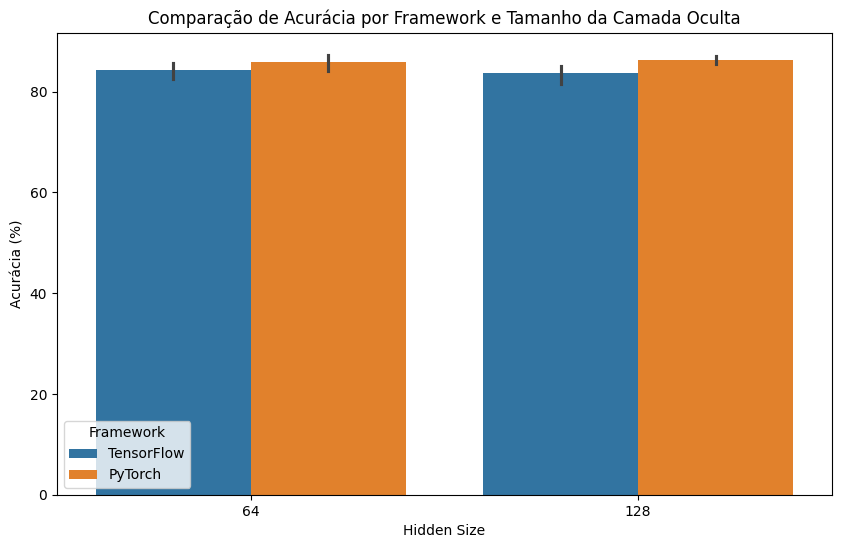

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=df_comparativo, x='hidden', y='acc', hue='Framework')
plt.title("Comparação de Acurácia por Framework e Tamanho da Camada Oculta")
plt.ylabel("Acurácia (%)")
plt.xlabel("Hidden Size")
plt.legend(title="Framework")
plt.show()


___
## **Parte 4:** Análise comparativa

#1. Desempenho dos modelos
Neste projeto utilizamos duas das principais bibliotecas de Deep Learning — TensorFlow/Keras e PyTorch — para treinar redes convolucionais (CNNs) aplicadas à classificação de imagens do dataset CIFAR-10. Após treinar ambos os modelos e realizar tuning de hiperparâmetros, foi possível observar pontos importantes que diferenciam as duas abordagens.

É possível perceber que o modelo com pytorch teve uma acurácia ligeiramente maior, mas não podemos tomar conclusões a partir disso. No aspecto técnico, TensorFlow/Keras oferece uma estrutura de codificação mais concisa e automatizada. A função model.fit() encapsula o processo de treinamento, facilitando experimentações rápidas. Já o PyTorch exige maior controle manual por meio de laços explícitos de treino e validação (for epoch), mas em contrapartida, permite maior flexibilidade na arquitetura e na manipulação do fluxo de dados.

Por fim, podemos concluir que não há um framework superior absoluto, mas sim contextos em que um pode ser mais vantajoso que o outro. TensorFlow/Keras é recomendado para quem busca rapidez e simplicidade na construção de modelos, enquanto PyTorch é ideal para quem precisa de maior controle e customização. O sucesso do modelo depende mais do cuidado com pré-processamento, ajuste de hiperparâmetros e análise dos resultados do que da escolha da ferramenta em si.

